# More flexibility over the training loop and samplers

Note, you can find the original version of this notebook at [https://github.com/sbi-dev/sbi/blob/main/tutorials/02_training_interface.ipynb](https://github.com/sbi-dev/sbi/blob/main/tutorials/02_training_interface.ipynb) in the `sbi` repository.

In the previous tutorials, we showed how `sbi` can be used to train neural networks and sample from the posterior. If you are an `sbi` power-user, then you might want more control over individual stages of this process. For example, you might want to write a custom training loop or more flexibility over the samplers that are used. In this tutorial, we will explain how you can achieve this.

In [1]:
import torch
from torch import ones, zeros, eye, float32, as_tensor, tensor
from torch.distributions import MultivariateNormal
from torch.optim import Adam

from sbi.utils import BoxUniform
from sbi.analysis import pairplot

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


As in the previous tutorials, we first define the prior and simulator and use them to generate simulated data: 

In [2]:
prior = BoxUniform(-3*ones((2,)), 3*ones((2,)))

def simulator(theta):
    return theta + torch.randn_like(theta) * 0.1

theta = prior.sample((1000,))
x = simulator(theta)

Below, we will first describe how you can run `Neural Posterior Estimation (NPE)`. We will attach code snippets for `Neural Likelihood Estimation (NLE)` and `Neural Ratio Estimation (NRE)` at the end.

# Neural Posterior Estimation

First, we have to decide on what `DensityEstimator` to use. In this tutorial, we will use a `Neural Spline Flow` (NSF) taken from the [`nflows`](https://github.com/bayesiains/nflows) package.

In [3]:
from sbi.neural_nets.flow import build_nsf

density_estimator = build_nsf(theta, x)

Every `density_estimator` in `sbi` implements at least two methods: `.sample()` and `.loss()`. Their input and output shapes are:


**`density_estimator.loss(input, condition)`:**
```
Args:
    input: `(batch_dim, *event_shape_input)`
    condition: `(batch_dim, *event_shape_condition)`

Returns:
    Loss of shape `(batch_dim,)`
```

**`density_estimator.sample(sample_shape, condition)`:**
```
Args:
    sample_shape: Tuple of ints which indicates the desired number of samples.
    condition: `(batch_dim, *event_shape_condition)`

Returns:
    Samples of shape `(sample_shape, batch_dim, *event_shape_input)`
```

Some `DensityEstimator`s, such as Normalizing flows, also allow to evaluate the `log probability`. In those cases, the `DensityEstimator` also has the following method:

**`density_estimator.log_prob(input, condition)`:**
```
Args:
    input: `(sample_dim, batch_dim, *event_shape_input)`
    condition: `(batch_dim, *event_shape_condition)`

Returns:
    Loss of shape `(sample_dim, batch_dim,)`
```

### Training the density estimator

We can now write our own custom training loop to train the above-generated `DensityEstimator`:

In [4]:
opt = Adam(list(density_estimator.parameters()), lr=5e-4)

for _ in range(100):
    opt.zero_grad()
    losses = density_estimator.loss(theta, condition=x)
    loss = torch.mean(losses)
    loss.backward()
    opt.step()

Given this trained `density_estimator`, we can already generate samples from the posterior given observations (but we have to adhere to the shape specifications of the `DensityEstimator` explained above:

In [5]:
x_o = torch.as_tensor([[1.0, 1.0]])
print(f"Shape of x_o: {x_o.shape}            # Must have a batch dimension")

samples = density_estimator.sample((1000,), condition=x_o).detach()
print(f"Shape of samples: {samples.shape}  # Samples are returned with a batch dimension.")

samples = samples.squeeze(dim=1)
print(f"Shape of samples: {samples.shape}     # Removed batch dimension.")

Shape of x_o: torch.Size([1, 2])            # Must have a batch dimension
Shape of samples: torch.Size([1000, 1, 2])  # Samples are returned with a batch dimension.
Shape of samples: torch.Size([1000, 2])     # Removed batch dimension.


/Users/michaeldeistler/anaconda3/envs/sbi/lib/python3.10/site-packages/nflows/transforms/lu.py:80: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:2190.)
  outputs, _ = torch.triangular_solve(


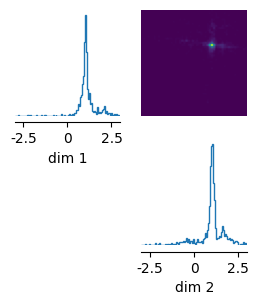

In [6]:
_ = pairplot(samples, limits=[[-3, 3], [-3, 3]], figsize=(3, 3))

You can also wrap the `DensityEstimator` as a `DirectPosterior`. The `DirectPosterior` is also returned by  `inference.build_posterior` and you have already learned how to use it in the [introduction tutorial](https://sbi-dev.github.io/sbi/dev/tutorials/00_getting_started_flexible/) and the [amortization tutotrial](https://sbi-dev.github.io/sbi/dev/tutorials/01_gaussian_amortized/). It adds the following functionality over the raw `DensityEstimator`:

- automatically reject samples outside of the prior bounds  
- compute the Maximum-a-posteriori (MAP) estimate



In [7]:
from sbi.inference.posteriors import DirectPosterior

posterior = DirectPosterior(density_estimator, prior)

In [8]:
print(f"Shape of x_o: {x_o.shape}   # For the `DirectPosterior`, the batch dimension is optional. Use `.sample_amortized` for multiple observations.")
samples = posterior.sample((1000,), x=x_o)
print(f"Shape of samples: {samples.shape}")

Shape of x_o: torch.Size([1, 2])   # For the `DirectPosterior`, the batch dimension is optional. Use `.sample_amortized` for multiple observations.


Drawing 1000 posterior samples:   0%|          | 0/1000 [00:00<?, ?it/s]

Shape of samples: torch.Size([1000, 2])


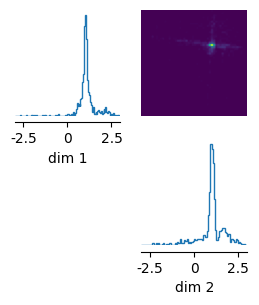

In [9]:
_ = pairplot(samples, limits=[[-3, 3], [-3, 3]], figsize=(3, 3))

# Neural Likelihood Estimation

The workflow for Neural Likelihood Estimation is very similar:

In [10]:
from sbi.neural_nets.flow import build_nsf
from sbi.inference.posteriors import MCMCPosterior
from sbi.inference.potentials import likelihood_estimator_based_potential

In [11]:
density_estimator = build_nsf(x, theta)  # Notice that the order of x and theta are reversed in comparison to NPE.

# Training loop.
opt = Adam(list(density_estimator.parameters()), lr=5e-4)
for _ in range(100):
    opt.zero_grad()
    losses = density_estimator.loss(x, condition=theta)
    loss = torch.mean(losses)
    loss.backward()
    opt.step()

# Build the posterior.
potential, tf = likelihood_estimator_based_potential(density_estimator, prior, x_o)
posterior = MCMCPosterior(
    potential,
    proposal=prior,
    theta_transform=tf,
    num_chains=100,
    thin=1,
    method="slice_np_vectorized"
)

Running vectorized MCMC with 100 chains:   0%|          | 0/26000 [00:00<?, ?it/s]

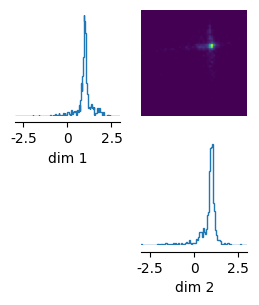

In [12]:
samples = posterior.sample((1000,), x=x_o)
_ = pairplot(samples, limits=[[-3, 3], [-3, 3]], figsize=(3, 3))

# Neural Ratio Estimation

Finally, for NRE, at this point, you have to implement the loss function yourself:

In [13]:
from sbi.neural_nets.classifier import build_resnet_classifier
from sbi.inference.posteriors import MCMCPosterior
from sbi.inference.potentials import ratio_estimator_based_potential
from sbi import utils as utils

In [14]:
net = build_resnet_classifier(x, theta)

In [15]:
opt = Adam(list(net.parameters()), lr=5e-4)


def classifier_logits(net, theta, x, num_atoms):
    batch_size = theta.shape[0]
    repeated_x = utils.repeat_rows(x, num_atoms)
    probs = ones(batch_size, batch_size) * (1 - eye(batch_size)) / (batch_size - 1)
    choices = torch.multinomial(probs, num_samples=num_atoms - 1, replacement=False)
    contrasting_theta = theta[choices]
    atomic_theta = torch.cat((theta[:, None, :], contrasting_theta), dim=1).reshape(
        batch_size * num_atoms, -1
    )
    return net(atomic_theta, repeated_x)


num_atoms = 10
for _ in range(300):
    opt.zero_grad()
    batch_size = theta.shape[0]
    logits = classifier_logits(net, theta, x, num_atoms=num_atoms)
    logits = logits.reshape(batch_size, num_atoms)
    log_probs = logits[:, 0] - torch.logsumexp(logits, dim=-1)
    loss = -torch.mean(log_probs)
    loss.backward()
    opt.step()

In [16]:
potential, tf = ratio_estimator_based_potential(net, prior, x_o)
posterior = MCMCPosterior(
    potential,
    proposal=prior,
    theta_transform=tf,
    num_chains=100,
    method="slice_np_vectorized"
)

/Users/michaeldeistler/Documents/phd/sbi/sbi/inference/posteriors/mcmc_posterior.py:115: UserWarning: The default value for thinning in MCMC sampling has been changed from 10 to 1. This might cause the results differ from the last benchmark.
  thin = _process_thin_default(thin)


Running vectorized MCMC with 100 chains:   0%|          | 0/26000 [00:00<?, ?it/s]

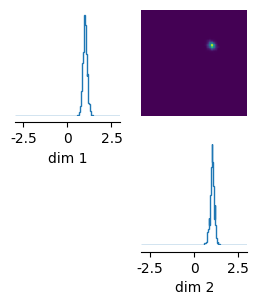

In [17]:
samples = posterior.sample((1000,), x=x_o)
_ = pairplot(samples, limits=[[-3, 3], [-3, 3]], figsize=(3, 3))